In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from math import sqrt
from sklearn.metrics import mean_squared_error
import warnings
from statlearning import plot_feature_importance
import matplotlib.pyplot as plt

In [2]:
#Import the train set and test set and combine the data
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

df_test['price'] = 0
df_all = pd.concat([df_train,df_test])
df_all.index = np.arange(2000)

In [3]:
df_train

,Id,price,experiences_offered,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_identity_verified,latitude,longitude,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month
0,1000,90,none,within an hour,1.00,f,11,f,51.547349,-0.219334,...,8.0,9.0,9.0,9.0,10.0,t,flexible,f,f,0.76
1,1001,120,none,NaN,NaN,f,1,f,51.550826,-0.208280,...,NaN,NaN,NaN,NaN,NaN,t,flexible,f,f,NaN
2,1002,100,none,NaN,NaN,t,1,f,51.489698,-0.194910,...,10.0,10.0,10.0,10.0,10.0,f,moderate,f,f,1.15
3,1003,89,none,within an hour,1.00,f,18,f,51.518718,-0.125574,...,9.0,10.0,10.0,10.0,9.0,f,strict_14_with_grace_period,f,f,2.26
4,1004,300,none,within a day,0.88,f,25,t,51.515499,-0.154633,...,NaN,NaN,NaN,NaN,NaN,f,flexible,f,f,NaN
5,1005,90,none,within an hour,1.00,f,7,t,51.489869,-0.228389,...,NaN,NaN,NaN,NaN,NaN,t,strict_14_with_grace_period,f,f,NaN
6,1006,40,none,within an hour,1.00,f,2,t,51.524937,-0.071451,...,NaN,NaN,NaN,NaN,NaN,t,flexible,f,f,NaN
7,1007,327,none,within an hour,0.96,f,1277,f,51.550765,-0.196139,...,10.0,10.0,10.0,8.0,6.0,t,strict_14_with_grace_period,f,f,0.05
8,1008,90,none,within a day,1.00,f,1,t,51.480024,-0.182333,...,10.0,9.0,10.0,10.0,10.0,f,strict_14_with_grace_period,f,f,0.96
9,1009,65,none,NaN,NaN,f,1,f,51.540791,-0.144308,...,NaN,NaN,NaN,NaN,NaN,f,flexible,f,f,NaN


In [4]:
# check the variables with numbers of null
df_all.isnull().sum()

Id                                    0
accommodates                          0
bathrooms                             6
bed_type                              0
bedrooms                              2
beds                                  3
cancellation_policy                   0
cleaning_fee                        472
experiences_offered                   0
extra_people                          0
guests_included                       0
host_identity_verified                1
host_is_superhost                     1
host_listings_count                   1
host_response_rate                  617
host_response_time                  617
instant_bookable                      0
latitude                              0
longitude                             0
maximum_nights                        0
minimum_nights                        0
number_of_reviews                     0
price                                 0
property_type                         0
require_guest_phone_verification      0


### filling the variables with null number

In [5]:
# define the null value in following nubmers with mean
for i in ['cleaning_fee','review_scores_accuracy','review_scores_checkin',
          'review_scores_cleanliness','review_scores_communication','review_scores_location',
         'review_scores_rating','review_scores_value','security_deposit','host_listings_count',
          'bathrooms','bedrooms','beds']:
    df_all[i] = df_all[i].apply(lambda x: float(df_all[i].mean()) if pd.isnull(x) else x)
    
# define the null value in following nubmers with zero
for i in ['host_response_rate','reviews_per_month']:
    df_all[i] = df_all[i].apply(lambda x: 0 if pd.isnull(x) else x)
    
# deal with the missing value in test set instead of deleting it straght away
df_all['host_identity_verified'] = df_all['host_identity_verified'].apply(lambda x: 'f' if pd.isnull(x) else x)    
df_all['host_is_superhost'] = df_all['host_is_superhost'].apply(lambda x: 'f' if pd.isnull(x) else x)    
df_all['host_response_time'] = df_all['host_response_time'].apply(lambda x: 'no response' if pd.isnull(x) else x)

In [6]:
def calc_distance( x1,x2,y1,y2 ):
    s = (x1 - x2)**2 + (y1 - y2)**2
    return np.sqrt(s)


In [7]:
latitude = df_all["latitude"]
longitude = df_all["longitude"]

# LONDON EYE
eye_lati = 51.503399 
eye_longi = -0.119519

In [8]:
distance = []
for i in np.arange(len(df_all)):
    distance.append( calc_distance(latitude[i],eye_lati, longitude[i],eye_longi  ) )


In [9]:
df_all["distance"] = distance

### Drop the column

In [10]:
df_clean = df_all.drop(['Id','experiences_offered','bedrooms',"latitude","longitude"],axis = 1)

### Get dummy

In [11]:
df_clean = df_clean.replace({'flexible':5,'moderate':4,'strict_14_with_grace_period':3,
                             'super_strict_30':2,'super_strict_60':1})
df_clean_dm = pd.get_dummies(df_clean)



#分出train和test
df_clean_dm_train = df_clean_dm.iloc[:1000,:]
df_clean_dm_test = df_clean_dm.iloc[1000:,:]

### Selecting the variable according to correlation

In [12]:
abs(df_clean_dm_train.corr()['price'])

accommodates                             0.649212
bathrooms                                0.473403
beds                                     0.531520
cancellation_policy                      0.269155
cleaning_fee                             0.509269
extra_people                             0.083662
guests_included                          0.352264
host_listings_count                      0.236387
host_response_rate                       0.217398
maximum_nights                           0.161332
minimum_nights                           0.000786
number_of_reviews                        0.092377
price                                    1.000000
review_scores_accuracy                   0.033478
review_scores_checkin                    0.032305
review_scores_cleanliness                0.013646
review_scores_communication              0.065249
review_scores_location                   0.017430
review_scores_rating                     0.037278
review_scores_value                      0.050687


In [13]:
correlation = df_clean_dm_train.corr()['price'].sort_values()
correlation_gd = correlation.loc[(correlation > 0.1)|(correlation < -0.1)]
#记得drop掉multicolinearity的predictor,比如beds和bedrooms

In [14]:
correlation_gd

room_type_Private room              -0.538836
cancellation_policy                 -0.269155
host_response_time_no response      -0.214364
distance                            -0.155694
maximum_nights                       0.161332
property_type_Serviced apartment     0.179138
host_response_time_within an hour    0.182686
host_response_rate                   0.217398
security_deposit                     0.232765
host_listings_count                  0.236387
guests_included                      0.352264
bathrooms                            0.473403
cleaning_fee                         0.509269
beds                                 0.531520
room_type_Entire home/apt            0.547153
accommodates                         0.649212
price                                1.000000
Name: price, dtype: float64

In [15]:
df_selected = df_clean_dm[correlation_gd.index].copy()
df_selected_test = df_clean_dm_test[correlation_gd.index].copy()
df_selected_train = df_clean_dm_train[correlation_gd.index].copy()
print(df_selected_train.shape)

(1000, 17)


### EDA

In [16]:
descriptive = df_clean_dm_train.describe()
descriptive.loc['skew', :] = df_clean_dm_train.skew()
descriptive.loc['kurt', :] = df_clean_dm_train.kurt()
descriptive

,accommodates,bathrooms,beds,cancellation_policy,cleaning_fee,extra_people,guests_included,host_listings_count,host_response_rate,maximum_nights,...,property_type_Townhouse,property_type_Treehouse,property_type_Villa,require_guest_phone_verification_f,require_guest_phone_verification_t,require_guest_profile_picture_f,require_guest_profile_picture_t,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.0,1000.0,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,3.104000,1.261277,1.640709,3.896000,42.239169,7.251000,1.534000,28.254000,0.644960,715.375000,...,0.041000,0.0,0.0,0.983000,0.017000,0.990000,0.010000,0.604000,0.390000,0.006000
std,1.786722,0.508005,1.133702,0.879749,30.399934,11.892411,1.209259,151.459359,0.456372,524.666911,...,0.198389,0.0,0.0,0.129336,0.129336,0.099549,0.099549,0.489309,0.487994,0.077266
min,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1.000000,1.000000,3.000000,20.000000,0.000000,1.000000,1.000000,0.000000,30.000000,...,0.000000,0.0,0.0,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,1.000000,1.000000,4.000000,43.657723,0.000000,1.000000,1.000000,0.980000,1125.000000,...,0.000000,0.0,0.0,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
75%,4.000000,1.500000,2.000000,5.000000,50.000000,15.000000,2.000000,4.000000,1.000000,1125.000000,...,0.000000,0.0,0.0,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000
max,13.000000,4.000000,12.000000,5.000000,300.000000,100.000000,11.000000,1277.000000,1.000000,1125.000000,...,1.000000,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
skew,1.397247,1.720292,2.364707,0.124267,2.112422,2.508350,3.320158,7.811469,-0.650628,-0.517556,...,4.636536,0.0,0.0,-7.483902,7.483902,-9.864173,9.864173,-0.425941,0.451729,12.812690
kurt,2.539075,3.277393,10.340671,-1.454297,9.791149,9.961284,14.151245,61.172735,-1.508582,-1.715451,...,19.536537,0.0,0.0,54.117024,54.117024,95.492892,95.492892,-1.822223,-1.799544,162.490010


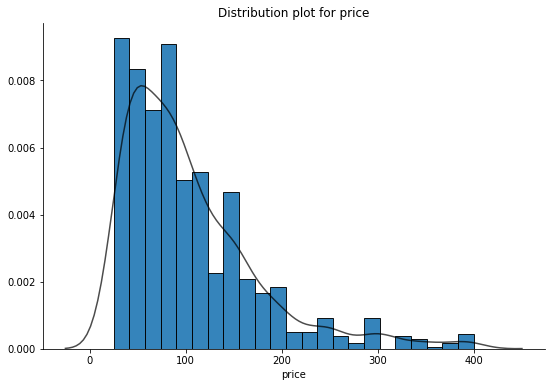

In [17]:
from statlearning import plot_histogram

fig, ax = plot_histogram(df_selected_train['price'])
ax.set_title('Distribution plot for price')
plt.savefig('distribution plot.png')
plt.show()

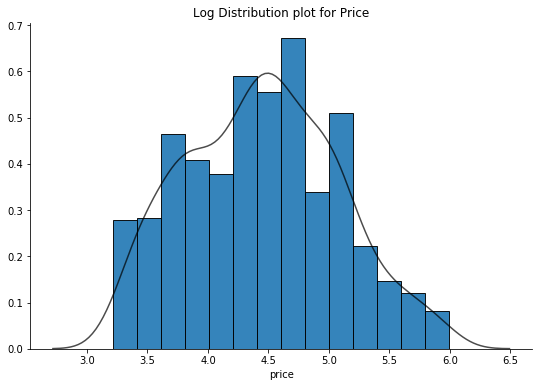

In [18]:
y_train_log = np.log(df_selected_train['price'])
fig, ax = plot_histogram(y_train_log)
ax.set_title('Log Distribution plot for Price')
plt.savefig('log distribution plot.png')
plt.show()

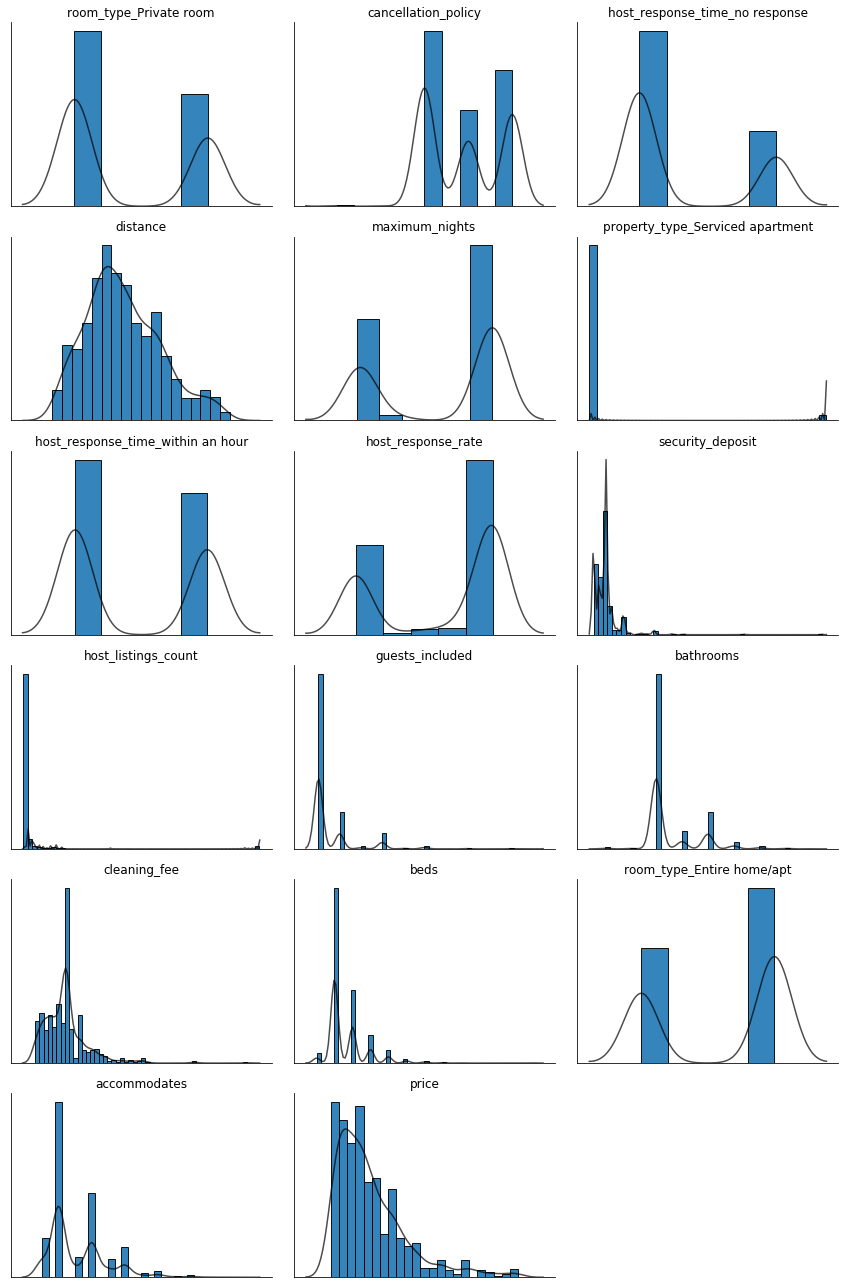

In [19]:
from statlearning import plot_histograms

plot_histograms(df_selected_train)
plt.show()

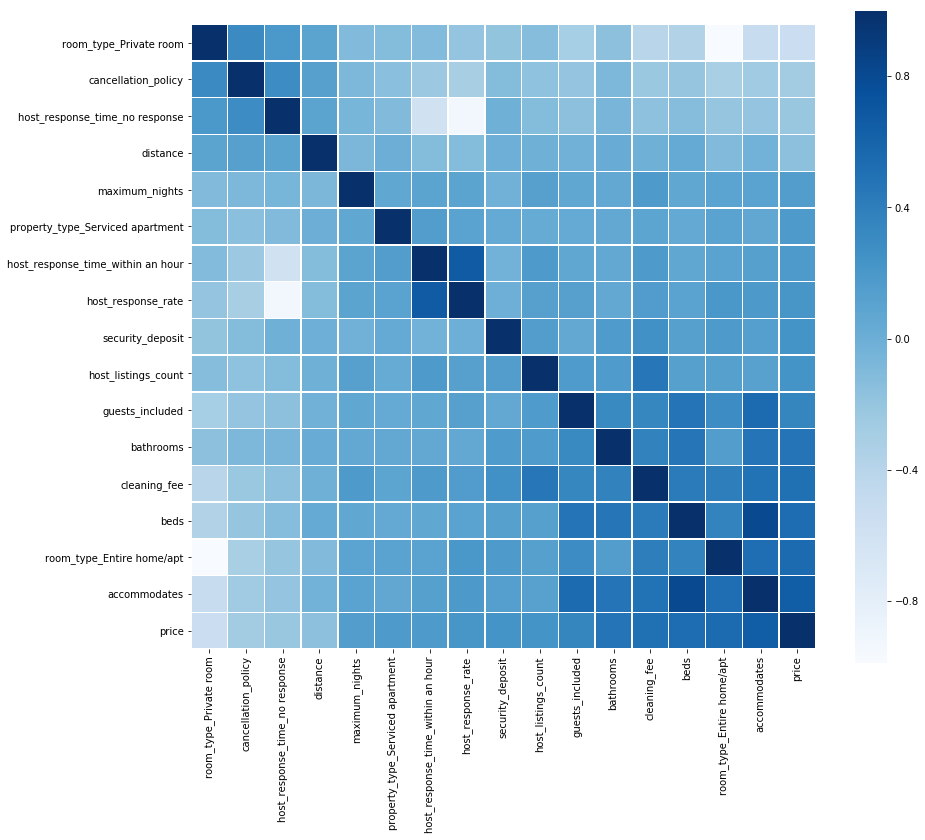

In [20]:
import seaborn as sns
df_cm = df_clean_dm_train[correlation_gd.index].corr()
#set up the matplotlib figure
plt.figure(figsize=(14,12))
sns.heatmap(df_cm,annot=False,cbar=True,square=True,cmap="Blues",fmt='.3g',linewidths=.5)

In [21]:
plt.rcParams['figure.figsize'] = (18, 6)


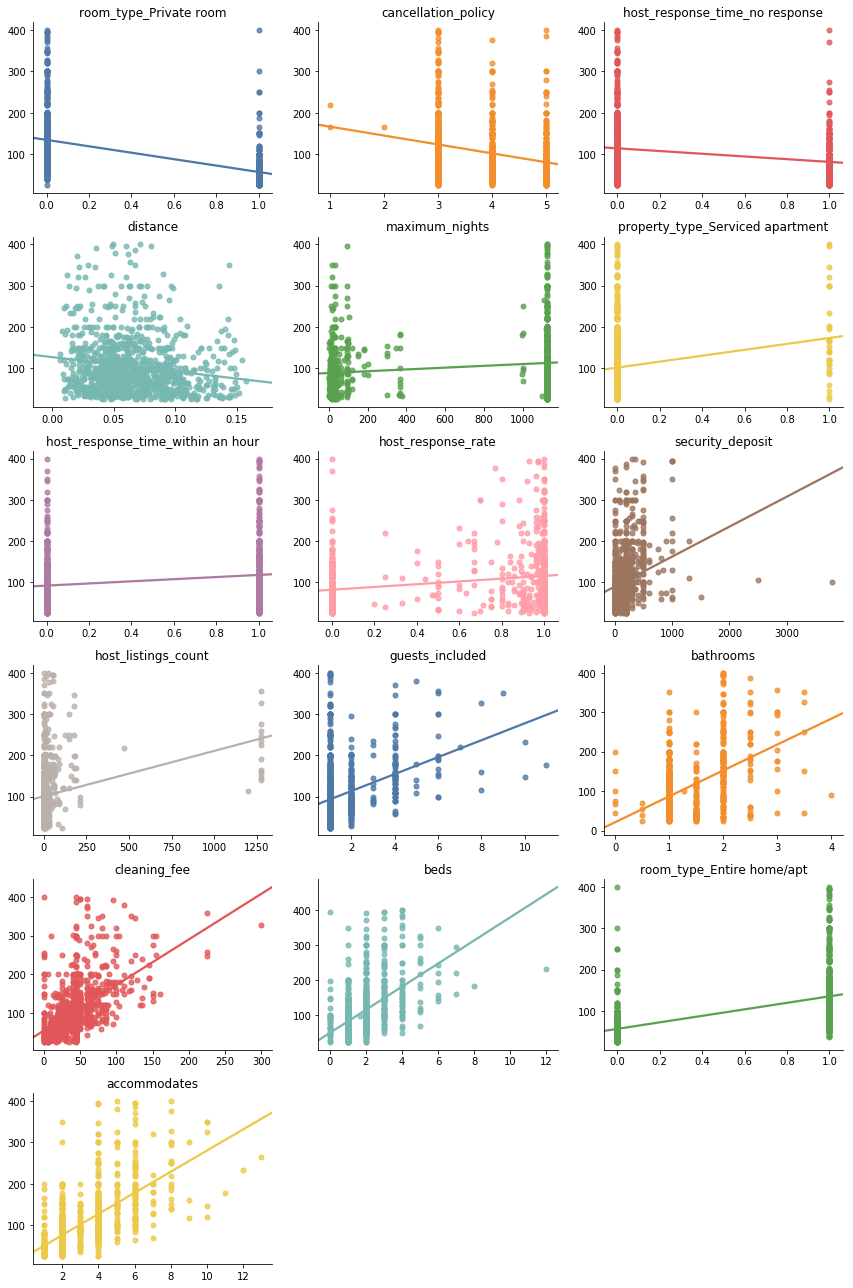

In [22]:
from statlearning import plot_regressions
import seaborn as sns
color = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']

with sns.color_palette(color):
    plot_regressions(df_selected_train.iloc[:,0:16], df_selected_train.iloc[:,16])
    plt.show()

In [23]:
df_selected_train.skew()

room_type_Private room               0.451729
cancellation_policy                  0.124267
host_response_time_no response       0.863806
distance                             0.525176
maximum_nights                      -0.517556
property_type_Serviced apartment     5.326174
host_response_time_within an hour    0.209448
host_response_rate                  -0.650628
security_deposit                     6.308771
host_listings_count                  7.811469
guests_included                      3.320158
bathrooms                            1.720292
cleaning_fee                         2.112422
beds                                 2.364707
room_type_Entire home/apt           -0.425941
accommodates                         1.397247
price                                1.645467
dtype: float64

### Log transformation

In [24]:
#log all
#df_selected_log1 = np.log1p(df_selected)

#selecting the price and accommodates variable to do log transformation.
for i in ['price','accommodates',"beds","cleaning_fee","bathrooms","guests_included","host_listings_count","security_deposit","property_type_Serviced apartment"]:
    df_selected_train[i] = np.log1p(df_selected_train[i])
    df_selected_test[i] = np.log1p(df_selected_test[i])







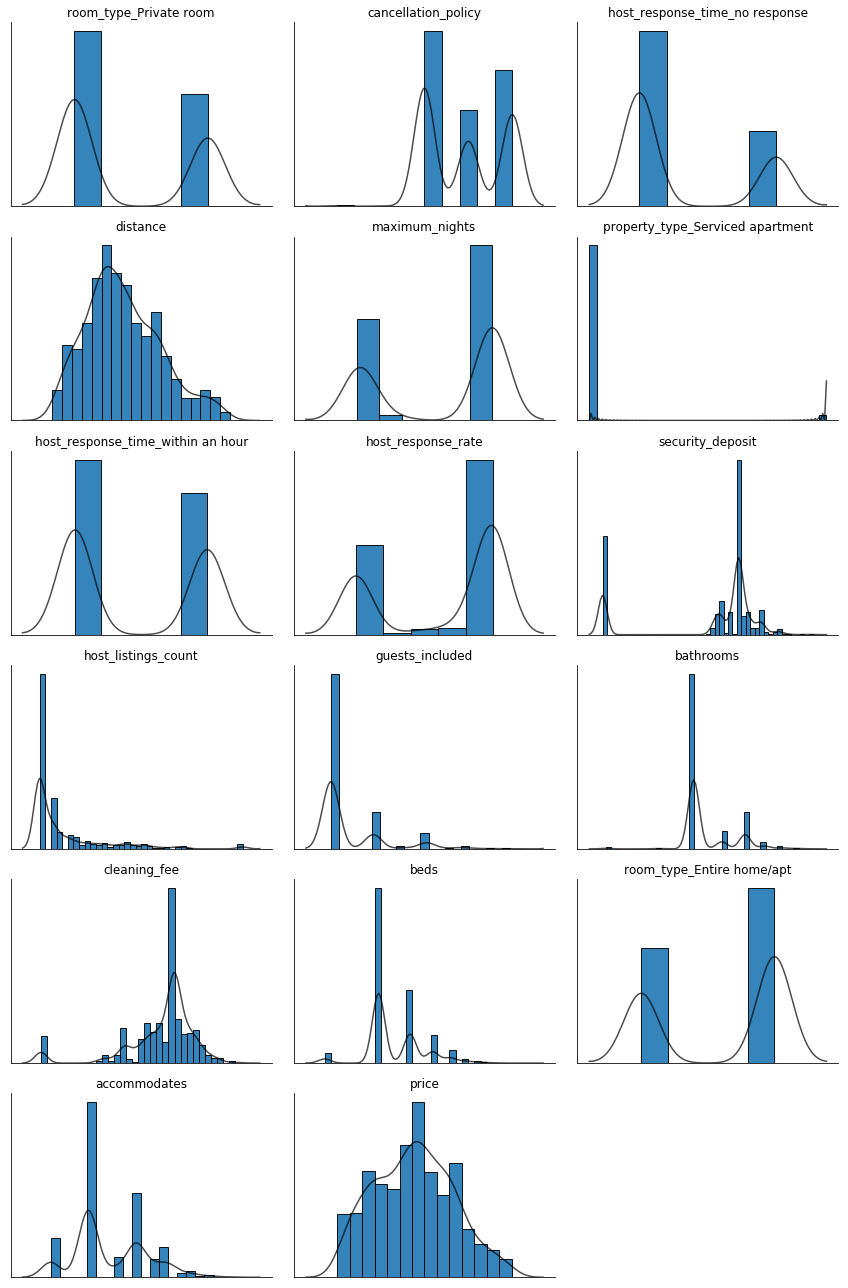

In [25]:
from statlearning import plot_histograms

plot_histograms(df_selected_train)
plt.show()

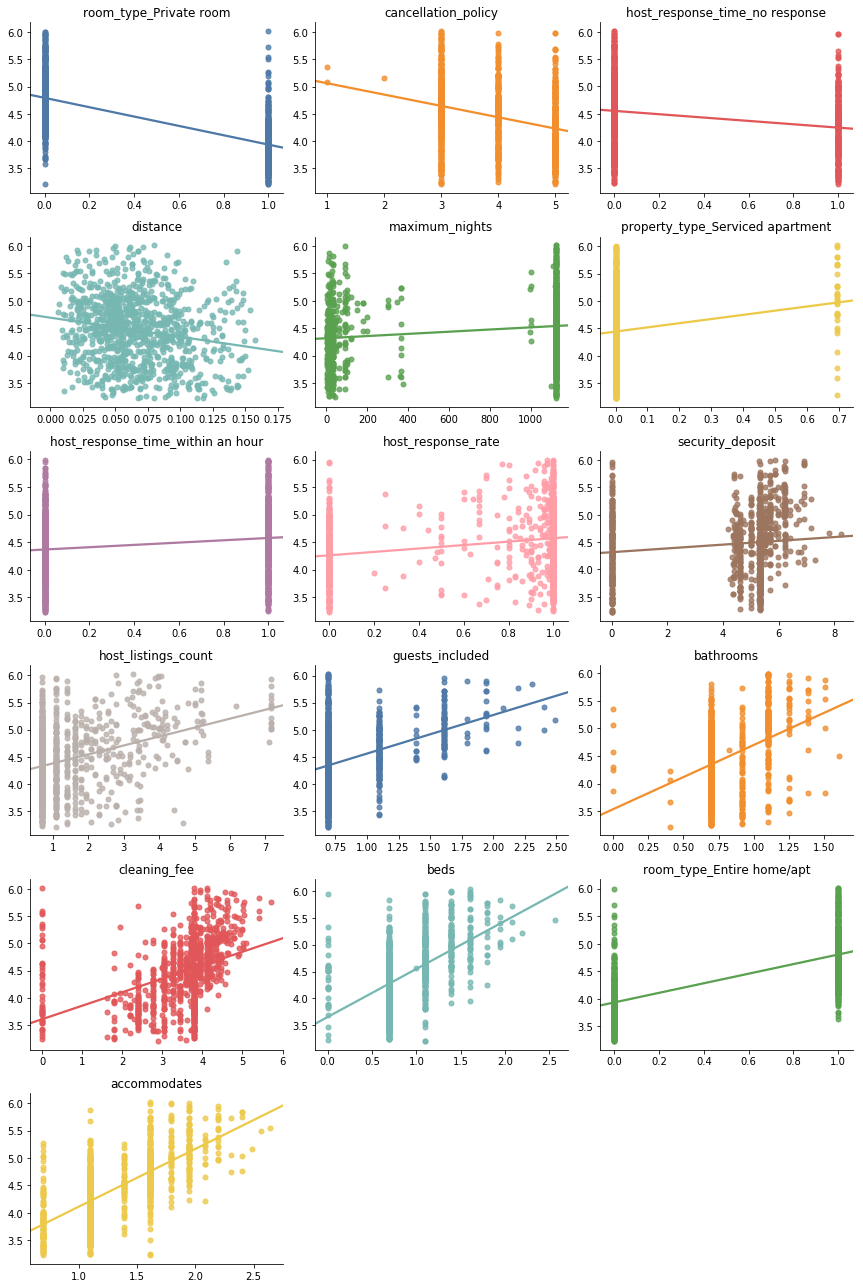

In [26]:
from statlearning import plot_regressions
import seaborn as sns
crayon = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']

with sns.color_palette(crayon):
    plot_regressions(df_selected_train.iloc[:,0:16], df_selected_train.iloc[:,16])
    plt.show()

In [27]:
df_selected_train

,room_type_Private room,cancellation_policy,host_response_time_no response,distance,maximum_nights,property_type_Serviced apartment,host_response_time_within an hour,host_response_rate,security_deposit,host_listings_count,guests_included,bathrooms,cleaning_fee,beds,room_type_Entire home/apt,accommodates,price
0,1,5,0,0.109062,1125,0.0,1,1.00,5.324492,2.484907,1.609438,1.609438,3.799027,1.609438,0,1.609438,4.510860
1,0,5,1,0.100637,1125,0.0,0,0.00,5.324492,0.693147,0.693147,1.098612,3.799027,1.098612,1,1.609438,4.795791
2,0,4,1,0.076626,1125,0.0,0,0.00,6.216606,0.693147,0.693147,0.693147,3.258097,0.000000,1,1.098612,4.615121
3,1,3,0,0.016472,1125,0.0,1,1.00,4.394449,2.944439,0.693147,0.693147,3.401197,1.098612,0,1.386294,4.499810
4,0,5,0,0.037141,1125,0.0,0,0.88,5.707110,3.258097,0.693147,1.098612,5.017280,1.386294,1,1.791759,5.707110
5,0,3,0,0.109707,1124,0.0,1,1.00,5.303305,2.079442,0.693147,0.916291,3.799027,1.386294,1,1.945910,4.510860
6,1,5,0,0.052673,1125,0.0,1,1.00,0.000000,1.098612,0.693147,0.693147,2.397895,0.693147,0,0.693147,3.713572
7,0,3,0,0.090079,1125,0.0,1,0.96,6.206576,7.153052,2.197225,1.504077,5.707110,1.609438,1,2.197225,5.793014
8,0,3,0,0.067022,14,0.0,0,1.00,5.303305,0.693147,0.693147,0.693147,3.583519,0.693147,1,1.098612,4.510860
9,1,5,1,0.044862,9,0.0,0,0.00,5.324492,0.693147,0.693147,0.693147,3.799027,0.693147,0,1.098612,4.189655


### X and Y

In [28]:
X_test_log1 = df_selected_test.iloc[:,0:-1]

### Standardise

In [29]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# scaler.fit(df_selected_train)


# train_log1_scale = scaler.transform(df_selected_train)




In [30]:
df_selected_train

,room_type_Private room,cancellation_policy,host_response_time_no response,distance,maximum_nights,property_type_Serviced apartment,host_response_time_within an hour,host_response_rate,security_deposit,host_listings_count,guests_included,bathrooms,cleaning_fee,beds,room_type_Entire home/apt,accommodates,price
0,1,5,0,0.109062,1125,0.0,1,1.00,5.324492,2.484907,1.609438,1.609438,3.799027,1.609438,0,1.609438,4.510860
1,0,5,1,0.100637,1125,0.0,0,0.00,5.324492,0.693147,0.693147,1.098612,3.799027,1.098612,1,1.609438,4.795791
2,0,4,1,0.076626,1125,0.0,0,0.00,6.216606,0.693147,0.693147,0.693147,3.258097,0.000000,1,1.098612,4.615121
3,1,3,0,0.016472,1125,0.0,1,1.00,4.394449,2.944439,0.693147,0.693147,3.401197,1.098612,0,1.386294,4.499810
4,0,5,0,0.037141,1125,0.0,0,0.88,5.707110,3.258097,0.693147,1.098612,5.017280,1.386294,1,1.791759,5.707110
5,0,3,0,0.109707,1124,0.0,1,1.00,5.303305,2.079442,0.693147,0.916291,3.799027,1.386294,1,1.945910,4.510860
6,1,5,0,0.052673,1125,0.0,1,1.00,0.000000,1.098612,0.693147,0.693147,2.397895,0.693147,0,0.693147,3.713572
7,0,3,0,0.090079,1125,0.0,1,0.96,6.206576,7.153052,2.197225,1.504077,5.707110,1.609438,1,2.197225,5.793014
8,0,3,0,0.067022,14,0.0,0,1.00,5.303305,0.693147,0.693147,0.693147,3.583519,0.693147,1,1.098612,4.510860
9,1,5,1,0.044862,9,0.0,0,0.00,5.324492,0.693147,0.693147,0.693147,3.799027,0.693147,0,1.098612,4.189655


In [31]:
from sklearn.model_selection import train_test_split

response='price'
predictors=list(df_selected_train.columns.values[:-1])

# Randomly split indexes
index_train, index_test  = train_test_split(np.array(df_selected_train.index), train_size=0.8, random_state=0)

# Write training and test sets 
train = df_selected_train.loc[index_train,:].copy()
validation =  df_selected_train.loc[index_test,:].copy()

# Write training and test response vectors
y_train = train[response]
y_validation = validation[response]


# Write training and test design matrices
X_train = train[predictors].copy()
X_validation = validation[predictors].copy()

def rmse(y_pred,y_test):
    return np.sqrt(mean_squared_error(y_pred, y_test))

### OLS

In [32]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scale = scaler.transform(X_train)

/Users/apple/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float16, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/apple/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype uint8, int64, float16, float64 were all converted to float64 by StandardScaler.
  """


In [33]:
from sklearn.linear_model import LinearRegression
ols = LinearRegression(fit_intercept = True)

ols.fit(X_train_scale, y_train )

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

### RMSE 

In [34]:
predicted  = ols.predict(X_validation)
rmse(y_validation,predicted)

26.919681297425143

### Ridge

In [35]:
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import Pipeline

alphas = list(np.logspace(-20,10,201, base=2))
ridge = Pipeline([
    ('scaler', StandardScaler()),
    ('estimator', RidgeCV(alphas=alphas, cv=5)),
])

ridge.fit(X_train, y_train)

/Users/apple/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float16, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/apple/anaconda3/lib/python3.6/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype uint8, int64, float16, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('estimator', RidgeCV(alphas=array([9.53674e-07, 1.05817e-06, ..., 9.22880e+02, 1.02400e+03]),
    cv=5, fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
    store_cv_values=False))])

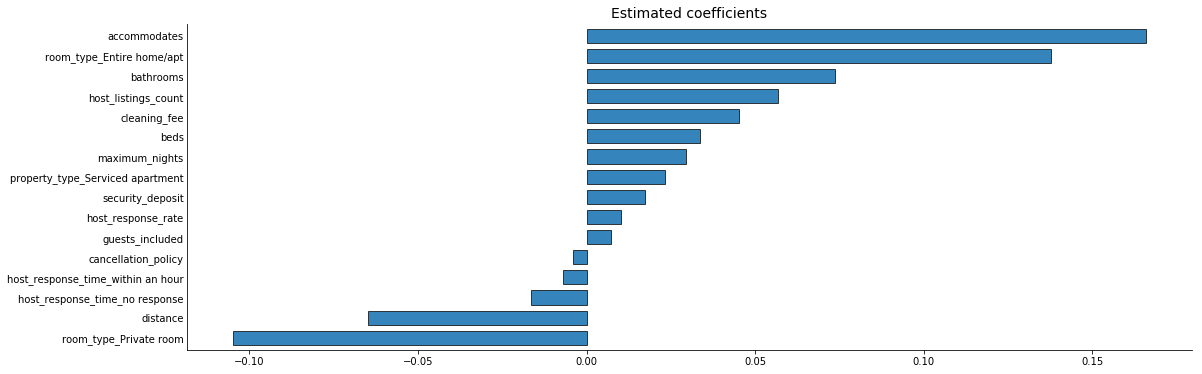

In [36]:
from statlearning import plot_coefficients
plot_coefficients(ridge._final_estimator,X_train.columns)
plt.show()

### Lasso

/Users/apple/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float16, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/apple/anaconda3/lib/python3.6/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype uint8, int64, float16, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


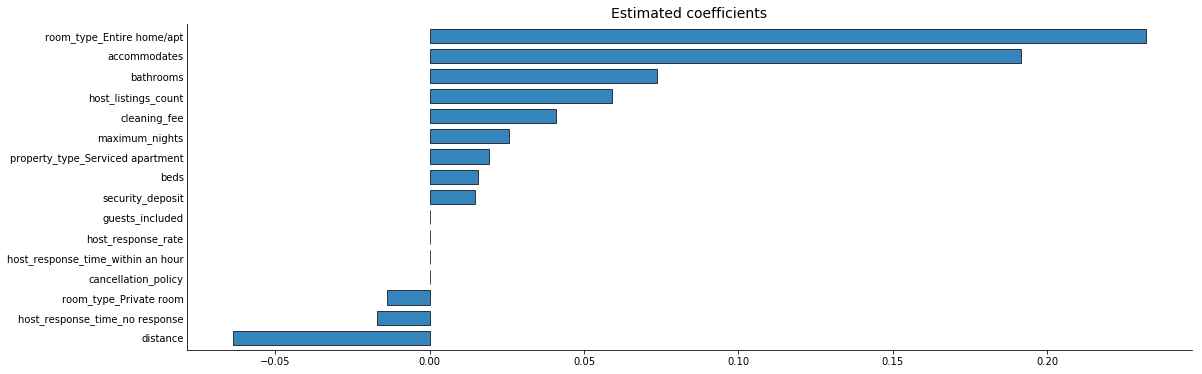

In [37]:
from sklearn.linear_model import LassoCV

alpha = list(np.logspace(-20,10,201, base=2))

lasso = Pipeline([
    ('scaler', StandardScaler()),
    ('estimator', LassoCV(random_state=0,alphas = alpha,cv=5)),
])

lasso.fit(X_train, y_train)

from statlearning import plot_coefficients

plot_coefficients(lasso._final_estimator,X_train.columns)
plt.savefig("lasso.png")
plt.show()

### Elastic net

/Users/apple/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float16, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/apple/anaconda3/lib/python3.6/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype uint8, int64, float16, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


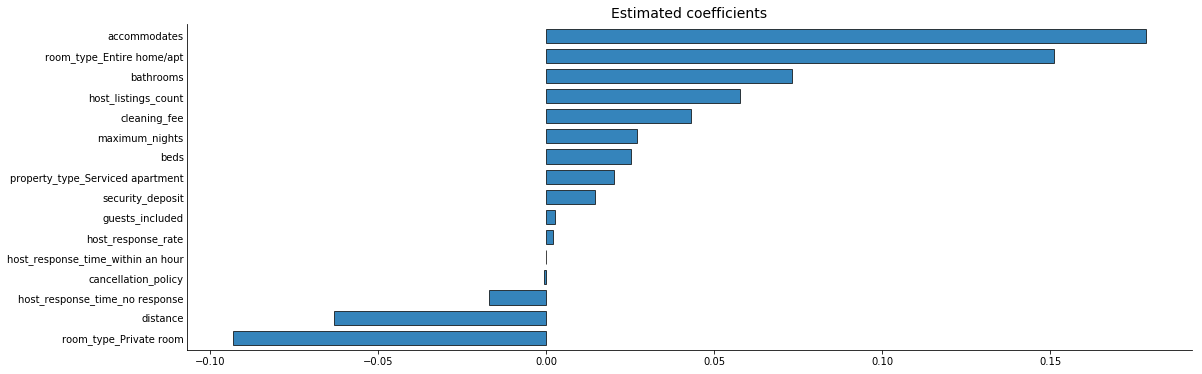

In [38]:
from sklearn.linear_model import ElasticNetCV

enet = Pipeline([
    ('scaler', StandardScaler()),
    ('estimator', ElasticNetCV(l1_ratio=[0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99], cv=5, n_alphas=200)),
])

enet.fit(X_train, y_train)

plot_coefficients(enet._final_estimator,X_train.columns)
plt.show()

In [39]:
from sklearn.metrics import mean_squared_error
columns2=['RMSE']
rows2=['Ridge','Lasso', 'Elastic Net']
results2=pd.DataFrame(0.0, columns=columns2, index=rows2) 


methods2=[ridge, lasso, enet]

for i, method in enumerate(methods2):
    y_pred=np.exp(method.predict(X_train))
    results2.iloc[i,0] = np.sqrt(mean_squared_error(y_train, y_pred))
    

results2

/Users/apple/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float16, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/apple/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float16, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/apple/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float16, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


,RMSE
Ridge,105.220332
Lasso,105.412393
Elastic Net,105.037801


In [41]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from statlearning import plot_feature_importance

### Random Foreast


In [42]:


rf_model = RandomForestRegressor(n_estimators=1000)

tuning_parameters = {
    'min_samples_leaf': [1,5, 10, 20, 50],
    'max_features': np.arange(1, len(X_train.columns)+1),
}

rf_search = RandomizedSearchCV(rf_model, tuning_parameters, cv = 10, n_iter= 16, return_train_score=False, n_jobs=4,
                              random_state = 20)
rf_search.fit(X_train, y_train)

rf = rf_search.best_estimator_

print('Best parameters found by randomised search:', rf_search.best_params_, '\n')

Best parameters found by randomised search: {'min_samples_leaf': 5, 'max_features': 5} 



### Xgboost


Best parameters found by randomised search: {'subsample': 1.0, 'n_estimators': 1000, 'max_depth': 2, 'learning_rate': 0.01} 



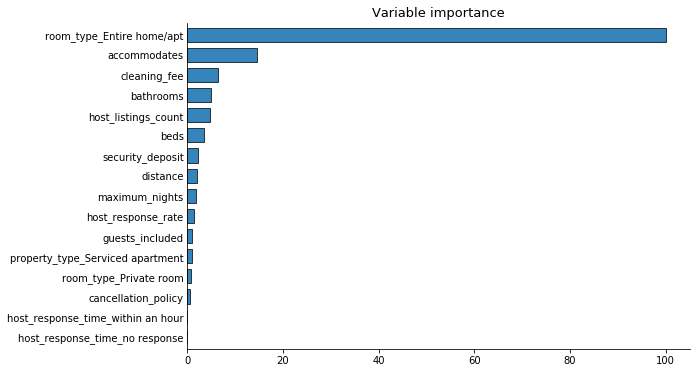

In [43]:

import xgboost as xgb

xgb_model = xgb.XGBRegressor()

tuning_parameters = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators' : [250, 500, 750, 1000, 1500],
    'max_depth' : [2, 3, 4],
    'subsample' : [0.6, 0.8, 1.0],
}

xgb_search = RandomizedSearchCV(xgb_model, tuning_parameters, n_iter = 16, cv = 5, return_train_score=False, n_jobs=4,
                              random_state = 20)
xgb_search.fit(X_train, y_train)

xbst = xgb_search.best_estimator_


print('Best parameters found by randomised search:', xgb_search.best_params_, '\n')

plot_feature_importance(xbst, labels=X_train.columns)
plt.show()

Selected number of boosting iterations: 99
RMSE (CV): 0.3197


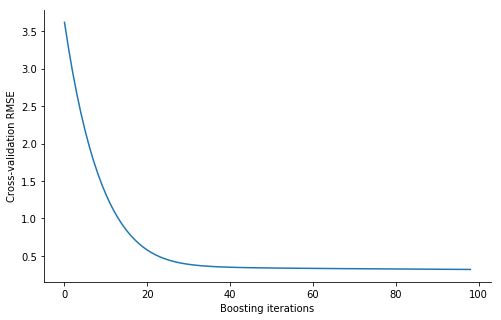

In [44]:

dtrain = xgb.DMatrix(X_train, y_train) 
# we need to convert the data to the format required by xgboost
#dtest  = xgb.DMatrix(X_test)

param = {
    'max_depth': 2, 
    'learning_rate': 0.1, 
    'subsample': 0.8,
    'silent' : 0, 
    'objective':'reg:linear',  
     }

cv = xgb.cv(param, dtrain, num_boost_round = 1500, nfold=10, early_stopping_rounds=50)

print(f'Selected number of boosting iterations: {cv.shape[0]}')
print(f'RMSE (CV): {cv.iloc[-1,0]:.4f}')

fig, ax = plt.subplots(figsize=(8,5))
plt.plot(cv.iloc[:,0])
ax.set_ylabel('Cross-validation RMSE')
ax.set_xlabel('Boosting iterations')
sns.despine()
plt.show()




In [45]:
columns=['Test RMSE']
rows=['Lasso', 'Ridge', 'Elastic Net','Random Forest','Xgboosting']
results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods=[lasso, ridge, enet,rf, xbst]

for i, method in enumerate(methods):
    y_pred3=np.exp(method.predict(X_train))
        
    results.iloc[i,0] = np.sqrt(mean_squared_error(y_train, y_pred3))


results.round(3)

/Users/apple/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float16, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/apple/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float16, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/apple/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float16, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


,Test RMSE
Lasso,105.412
Ridge,105.220
Elastic Net,105.038
Random Forest,106.800
Xgboosting,107.474


### Model Stacking

In [46]:

from mlxtend.regressor import StackingCVRegressor


models = [ols, lasso, ridge, xbst]

stack = StackingCVRegressor(models, meta_regressor = LinearRegression(), cv=10)
stack.fit(X_train.as_matrix(), y_train.as_matrix())

pred_stack = stack.predict(X_test_log1.as_matrix())

### Submit

In [47]:
lasso_output = lasso.predict(X_test_log1.values)
test_output = df_test.copy()
test_output['price'] = lasso_output
test_output[['Id','price']].to_csv('test1.csv',index = None)

ridge_output = ridge.predict(X_test_log1.values)
test_output = df_test.copy()
test_output['price'] = ridge_output
test_output[['Id','price']].to_csv('test2.csv',index = None)


enet_output = enet.predict(X_test_log1.values)
test_output = df_test.copy()
test_output['price'] = enet_output
test_output[['Id','price']].to_csv('test3.csv',index = None)


rf_output = rf.predict(X_test_log1.values)
test_output = df_test.copy()
test_output['price'] = rf_output
test_output[['Id','price']].to_csv('test4.csv',index = None)


xbst_output = xbst.predict(X_test_log1)
test_output = df_test.copy()
test_output['price'] =  xbst_output
test_output[['Id','price']].to_csv('test5.csv',index = None)

In [49]:
# pred_ols = ols_model.predict(X_test_log1)
#一定要非常注意pred要转换回去
submission = pd.DataFrame(np.c_[np.arange(0,1000),np.exp(pred_stack)-1], columns=['Id', 'price'])
submission['Id'] = submission['Id'].astype(int)
submission.to_csv('kaggle_submission.csv',  index=False)

In [50]:
submission

,Id,price
0,0,143.818557
1,1,210.974044
2,2,175.242294
3,3,90.720902
4,4,146.378168
5,5,80.031277
6,6,94.249230
7,7,154.319238
8,8,79.215127
9,9,94.877355
